# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  LSTM: lstm (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

Cross validation GRU 
save plots
implement script pipeline for training
Start to read papers

In [1]:
%load_ext autoreload
%autoreload 2

from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
# clips_reduction = CLIPS_REDUCTION.MEAN
# embedding_reduction = None
clips_reduction = None
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW

# path_labels = os.path.join('partA','starting_point','samples.csv')
# 'original' : os.path.join('partA','starting_point','subsamples_60_240.csv'),
# path_dict ={
  
#   'train' : os.path.join('partA','starting_point','train_191.csv'),
#   'val' : os.path.join('partA','starting_point','val_26.csv'),
#   'test' : os.path.join('partA','starting_point','test_23.csv')
# }
path_dict ={
  
  'train' : os.path.join('partA','starting_point','train_21.csv'),
  'val' : os.path.join('partA','starting_point',''),
  'test' : os.path.join('partA','starting_point','test_5.csv')
}

path_dataset = os.path.join('partA','video','video')  
# head = HeadSVR(svr_params={'kernel':'rbf','C':1,'epsilon':10})
head = 'GRU'

params = {
  'hidden_size': 512,
  'num_layers': 1,
  'dropout': 0.0
}
# print(f'\npath_labels: {path_labels}\n')

preprocess = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")

model_advanced = Model_Advanced(model_type=model_type,
                                path_dataset=path_dataset,
                                embedding_reduction=embedding_reduction,
                                clips_reduction=clips_reduction,
                                sample_frame_strategy=sample_frame_strategy,
                                stride_window=70,
                                path_labels=path_dict,
                                preprocess=preprocess,
                                batch_size=1,
                                head=head,
                                head_params=params,
                                download_if_unavailable=True
                                ) 

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:458: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Set path_labels: partA/starting_point/train_21.csv
head_params : {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.0, 'input_size': 6144}
output_tensor : [1, 8, 1, 1, 768]


In [2]:
model_advanced.head

In [2]:
import torch
torch.cuda.is_available()

True

In [61]:
# Save plots in folder
# Cross-validation using GRU

Training using GRU...
Set path_labels: partA/starting_point/train_21.csv
extracting features using.... cuda
unique_id: [7812]
unique_id: [4719]
unique_id: [6]
unique_id: [6011]
unique_id: [6020]
unique_id: [6007]
unique_id: [7819]
unique_id: [4724]
unique_id: [2935]
unique_id: [1826]
unique_id: [4721]
unique_id: [4726]
unique_id: [6931]
unique_id: [6043]
unique_id: [60]
unique_id: [6050]
unique_id: [6963]
unique_id: [7878]
unique_id: [68]
unique_id: [6079]
unique_id: [6964]
Feature extraceton done
Set path_labels: partA/starting_point/test_5.csv
extracting features using.... cuda
unique_id: [1231]
unique_id: [1236]
unique_id: [7440]
unique_id: [7435]
unique_id: [7490]
Feature extraceton done
Device: cuda
Epoch [1/2] | Train Loss: 1.0702 | Test Loss: 0.6623
	Train Loss Per Class: [10.95322478  2.7575407   1.45684683  7.30756342  0.        ]
	Test Loss Per Class: [0.        0.2391392 0.        0.        3.0722487]
	Train Loss Per Subject: [3.40486562 0.         0.23772573 0.75954771 3.11

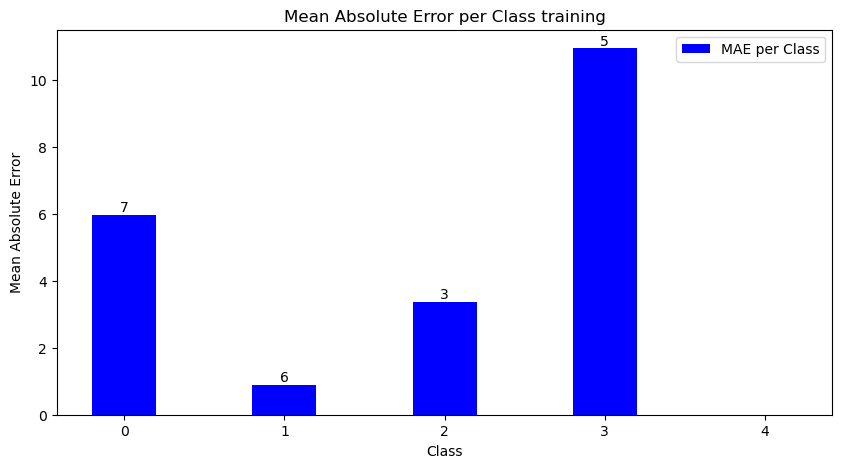

unique_classes shape (5,)
mae_per_class shape (5,)


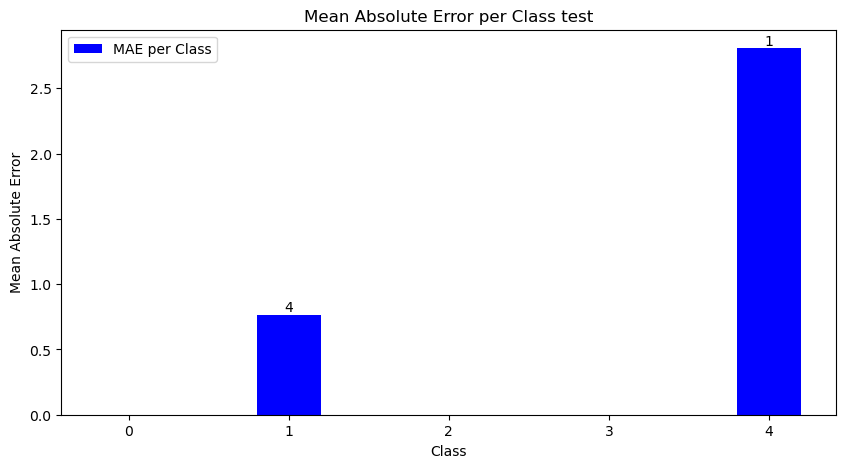

uniqie_subject_ids shape (9,)
mae_per_subject shape (9,)


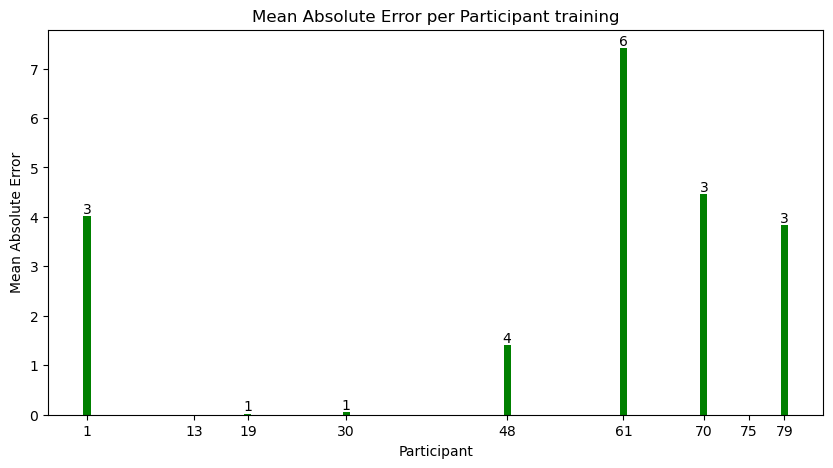

uniqie_subject_ids shape (9,)
mae_per_subject shape (9,)


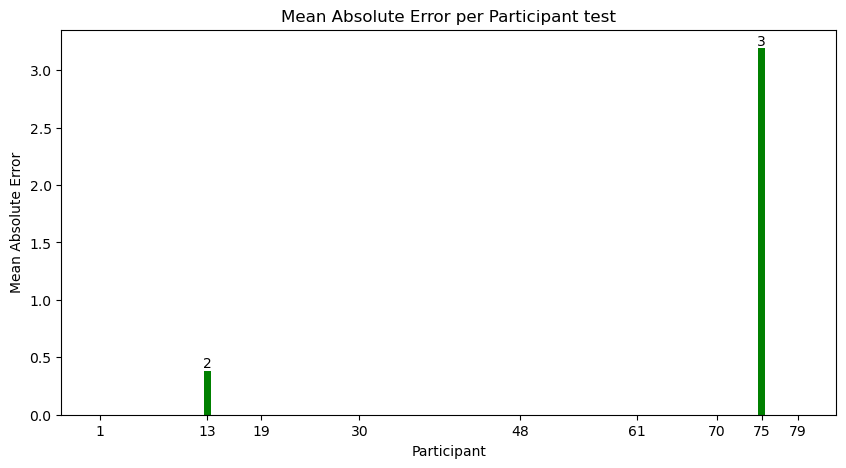

In [39]:
results = model_advanced.train()

In [40]:
import numpy as np
print(np.round(results['train_loss_per_subject'][-1],3))
print(np.round(results['test_loss_per_subject'][-1],3))

[4.02  0.    0.023 0.057 1.405 7.414 4.46  0.    3.829]
[0.    0.382 0.    0.    0.    0.    0.    3.192 0.   ]


In [37]:
results['subject_ids_unique']

array([ 1, 13, 19, 30, 48, 61, 70, 75, 79], dtype=int16)

In [41]:
result_cross_validation=model_advanced.cross_validation(k=3)

GRU with k-fold cross-validation...
Set path_labels: partA/starting_point/train_21.csv
extracting features using.... cuda
unique_id: [7812]
unique_id: [4719]
unique_id: [6]
unique_id: [6011]
unique_id: [6020]
unique_id: [6007]
unique_id: [7819]
unique_id: [4724]
unique_id: [2935]
unique_id: [1826]
unique_id: [4721]
unique_id: [4726]
unique_id: [6931]
unique_id: [6043]
unique_id: [60]
unique_id: [6050]
unique_id: [6963]
unique_id: [7878]
unique_id: [68]
unique_id: [6079]
unique_id: [6964]
Feature extraceton done
Starting Fold 1/3
X_train shape torch.Size([17, 2, 8, 1, 1, 768])
y_train shape torch.Size([17, 1])
groups_train shape (17,)
Device: cuda
Epoch [1/5] | Train Loss: 1.4208 | Test Loss: 0.9980
	Train Loss Per Class: [10.71335721  3.3298651   2.98541498  7.12540221]
	Test Loss Per Class: [1.00373971 0.00368917 0.98841059 1.99622452]
	Train Loss Per Subject: [0.         0.         0.23746842 4.70917004 8.39136863 3.91254568
 6.90348673]
	Test Loss Per Subject: [3.98837483e+00 3.6891

In [42]:
import numpy as np
print(np.round(result_cross_validation[2]['train_loss_per_subject'],3))
print(np.round(result_cross_validation[2]['test_loss_per_subject'],3))

[[0.    0.    0.177 4.299 9.922 2.34  3.021]
 [0.    0.    0.283 1.599 7.66  4.052 4.328]
 [0.    0.    0.321 1.545 6.985 3.895 4.244]
 [0.    0.    0.034 1.351 7.238 3.666 3.964]
 [0.    0.    0.211 1.441 7.176 3.6   3.997]]
[[4.265 0.459 0.    0.    0.    0.    0.   ]
 [4.006 0.219 0.    0.    0.    0.    0.   ]
 [3.958 0.048 0.    0.    0.    0.    0.   ]
 [3.874 0.029 0.    0.    0.    0.    0.   ]
 [3.89  0.043 0.    0.    0.    0.    0.   ]]


unique_classes shape torch.Size([5])
mae_per_class shape (5,)


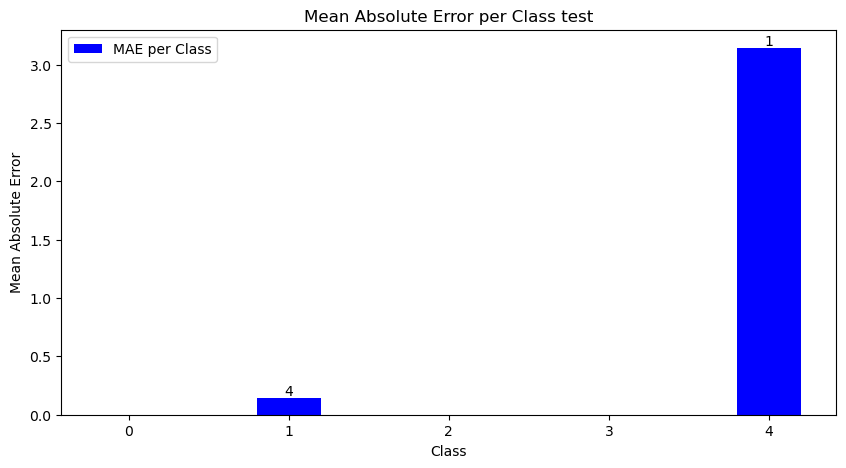

In [67]:
%autoreload 2
import custom.tools as tools

_,count_y_train=model_advanced.dataset.get_unique_subjects_and_classes()
count_y_train
tools.plot_mea_per_class(title='test', mae_per_class=results['test_loss_per_class'][-1], unique_classes=results['y_unique'], count_classes=count_y_train)

In [42]:
results['test_loss_per_subject']

array([[0.        , 0.42289877, 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.14097559, 0.        ],
       [0.        , 0.03815454, 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.03815925, 0.        ]])

Set path_labels: partA/starting_point/test_23.csv
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature extracetion done
Computing features...
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


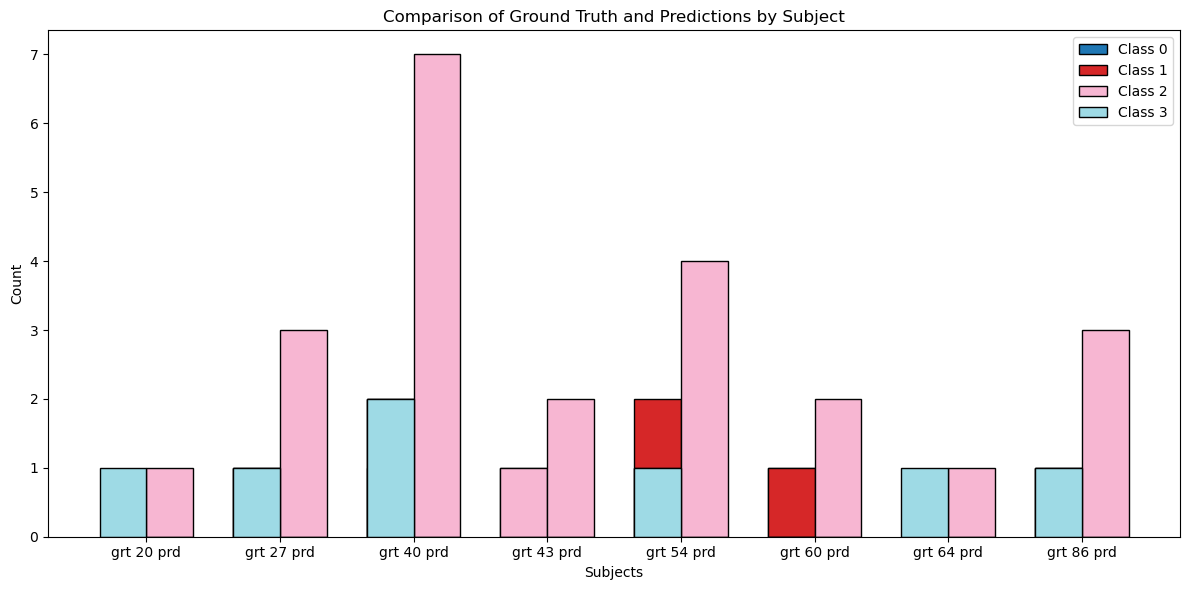

In [4]:
%autoreload 2

model_advanced.dataset.set_path_labels('test')
model_advanced.plot_comparison_prediction_gt()

Set path_labels: partA/starting_point/val_26.csv
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature extracetion done
(26, 768

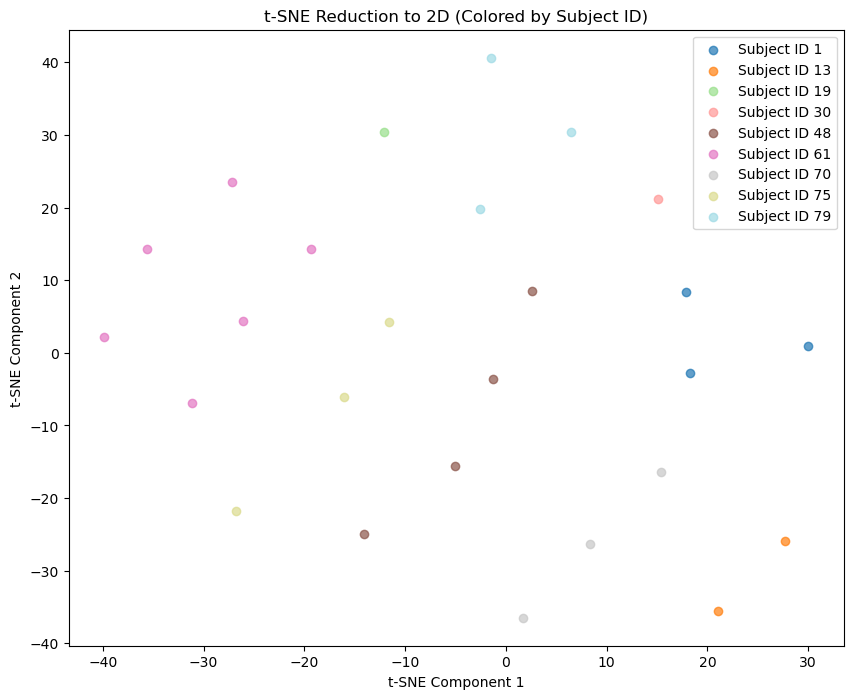

In [4]:
model_advanced.dataset.set_path_labels('val')
model_advanced.plot_tsne('subject',use_cuda=True)

extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature extracetion done


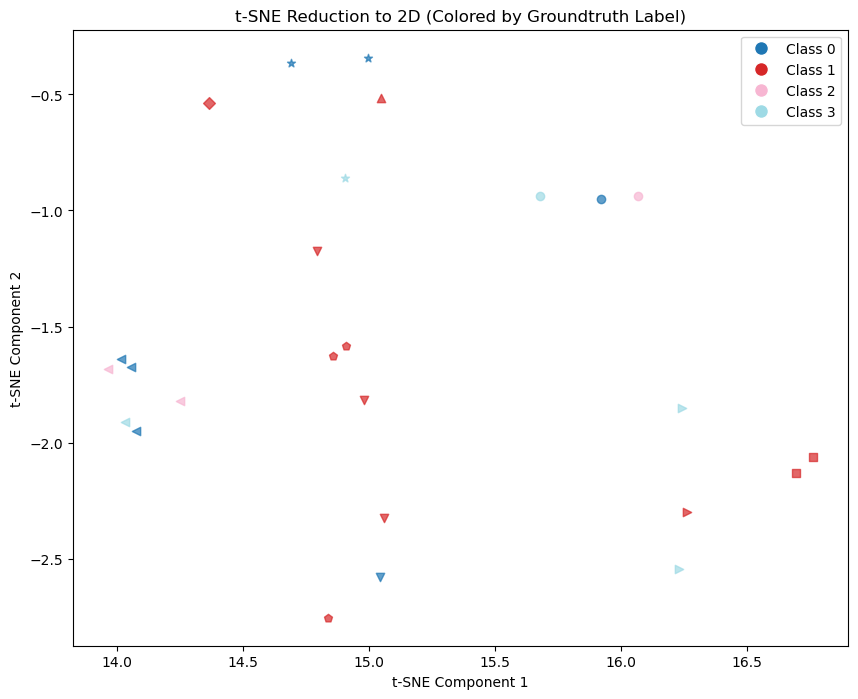

In [10]:
model_advanced.plot_tsne_colored_fixed_subject(color_by='gt',use_cuda=True)

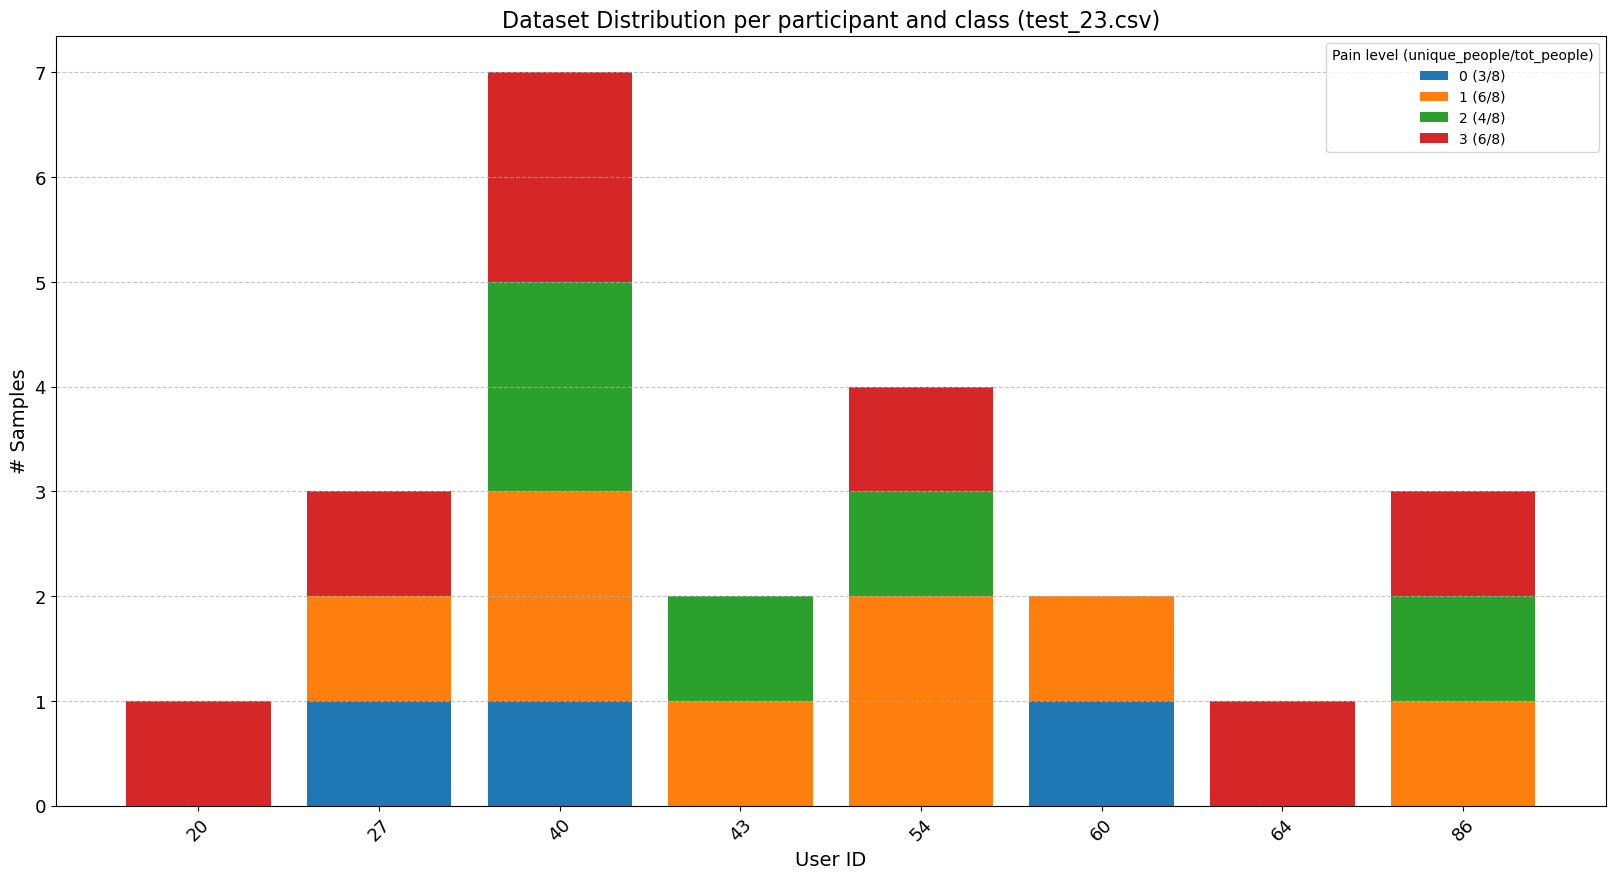

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
traindataset
Set path_labels: partA/starting_point/train_191.csv


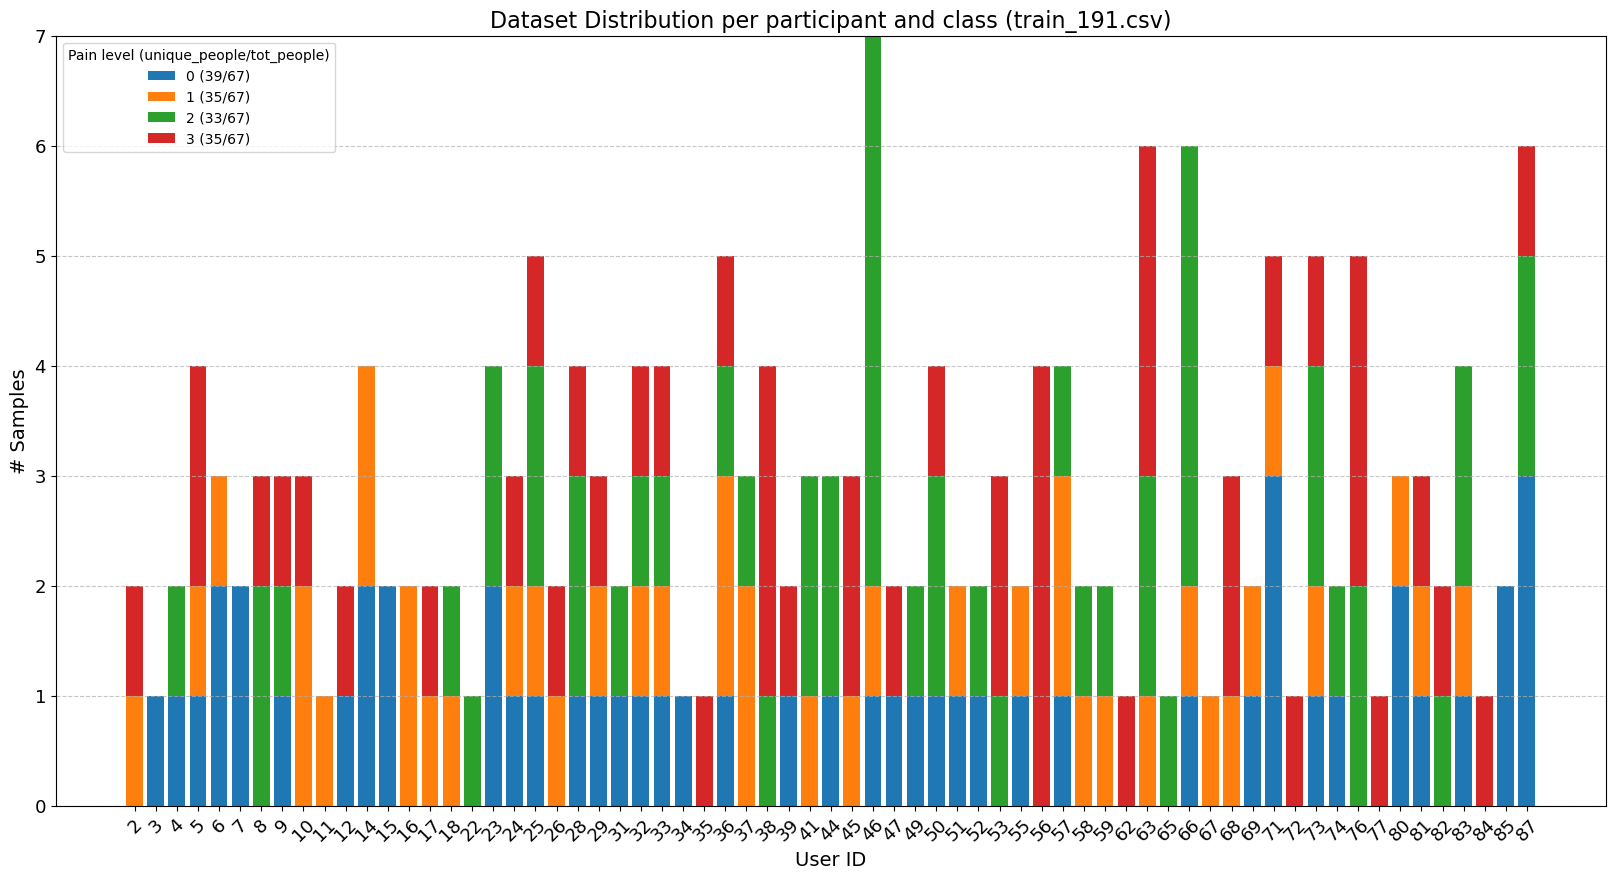

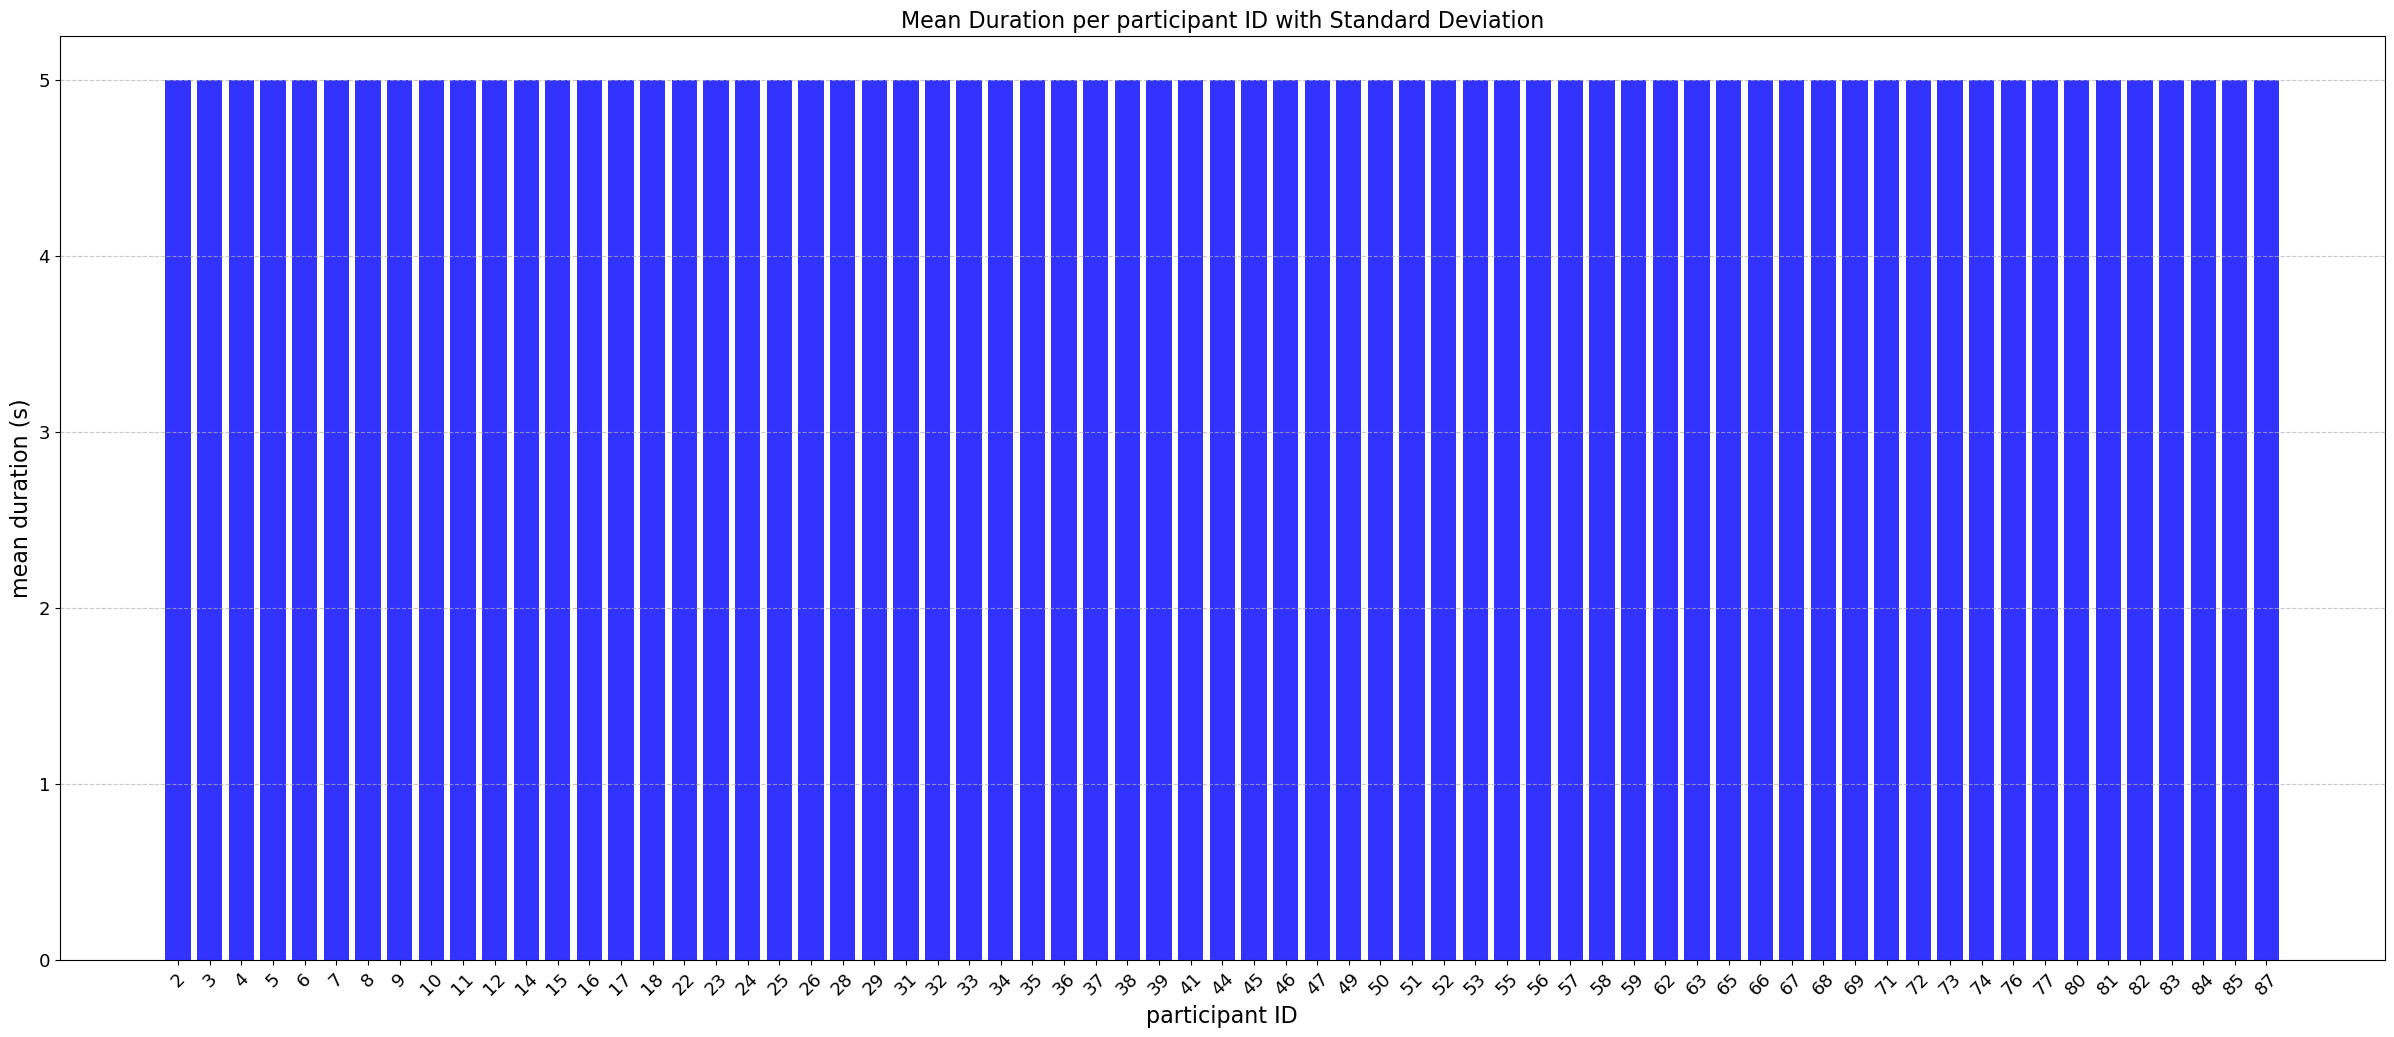

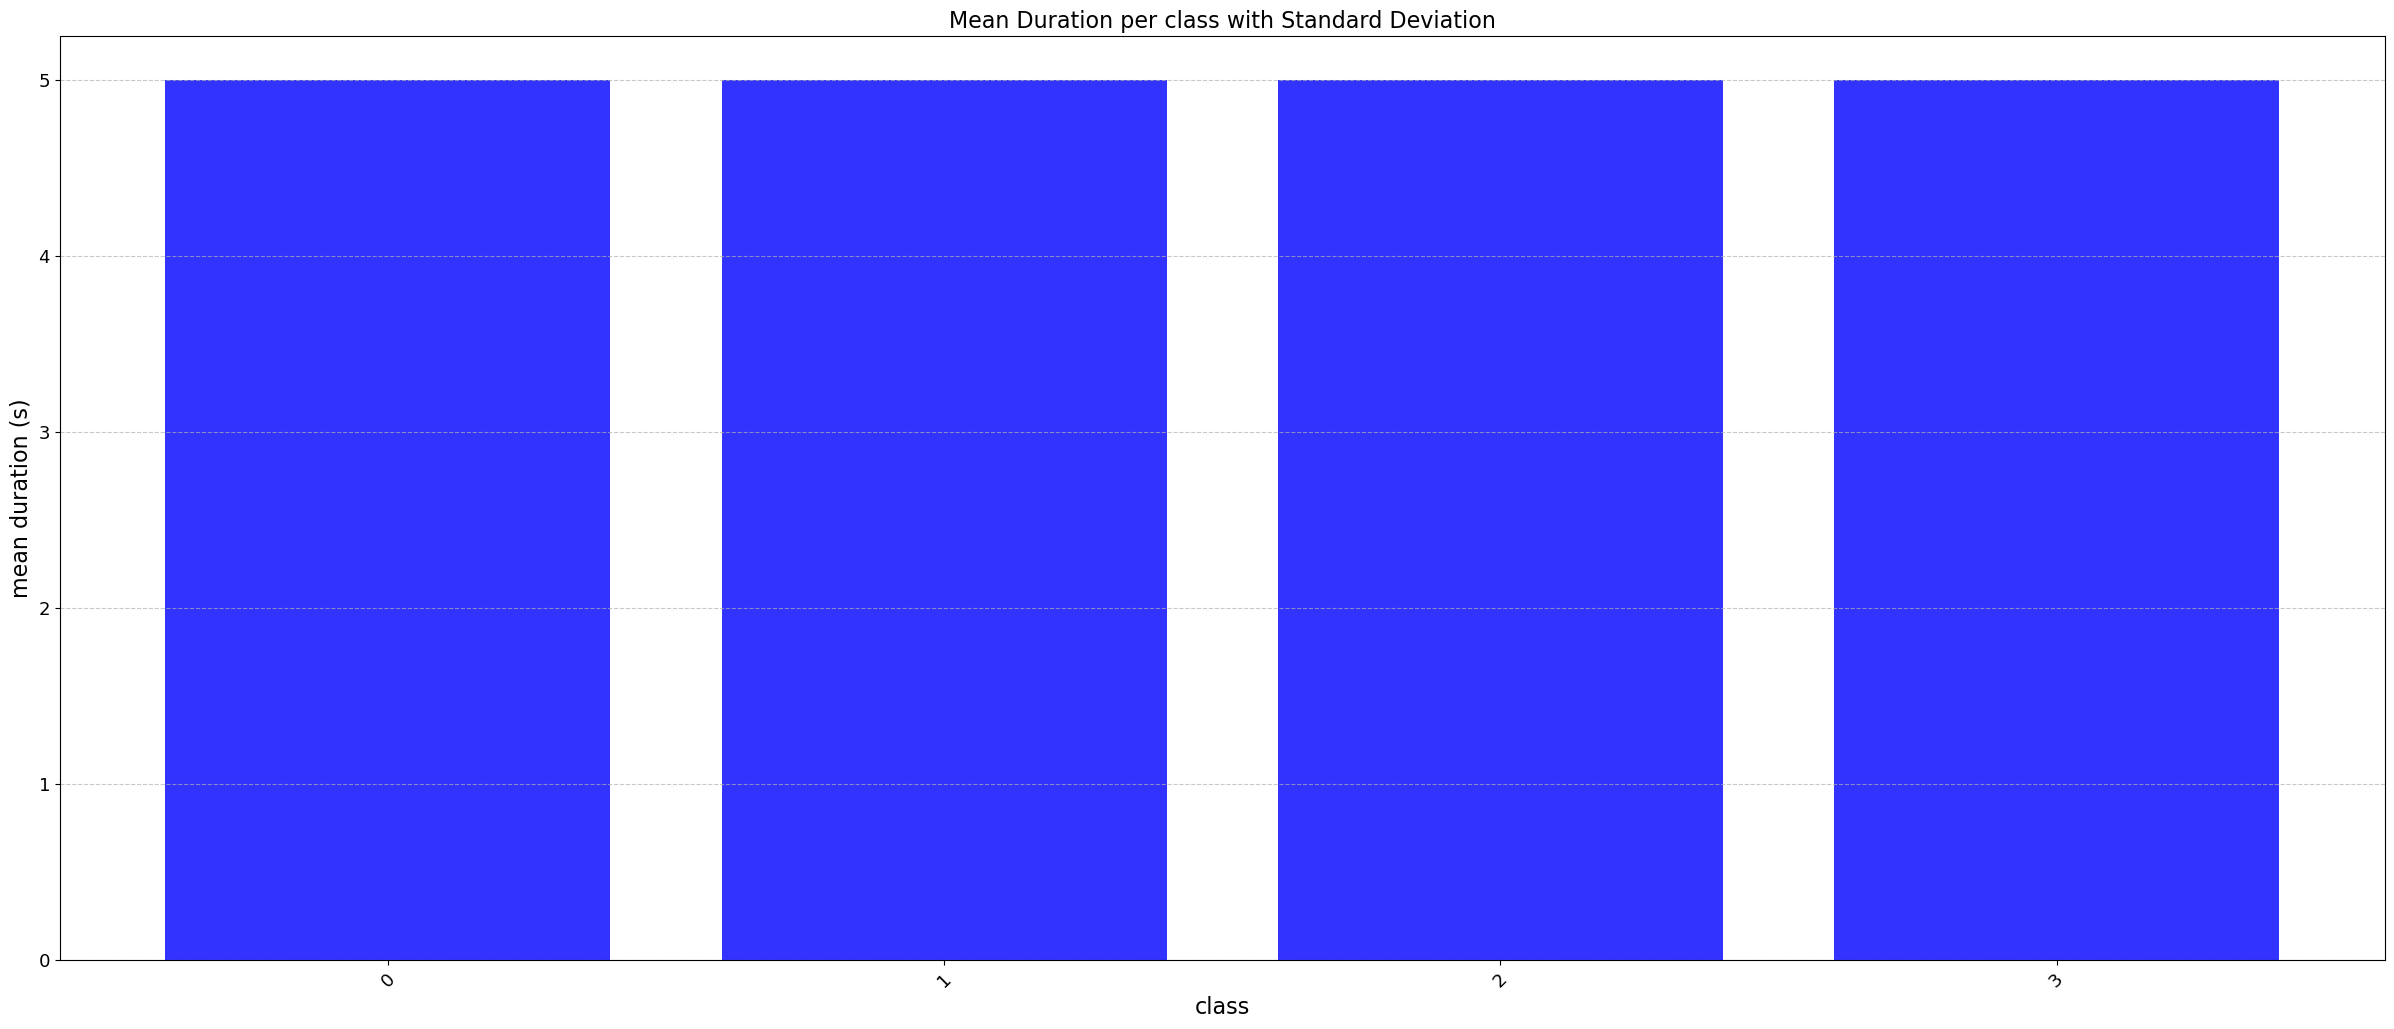

valdataset
Set path_labels: partA/starting_point/val_26.csv


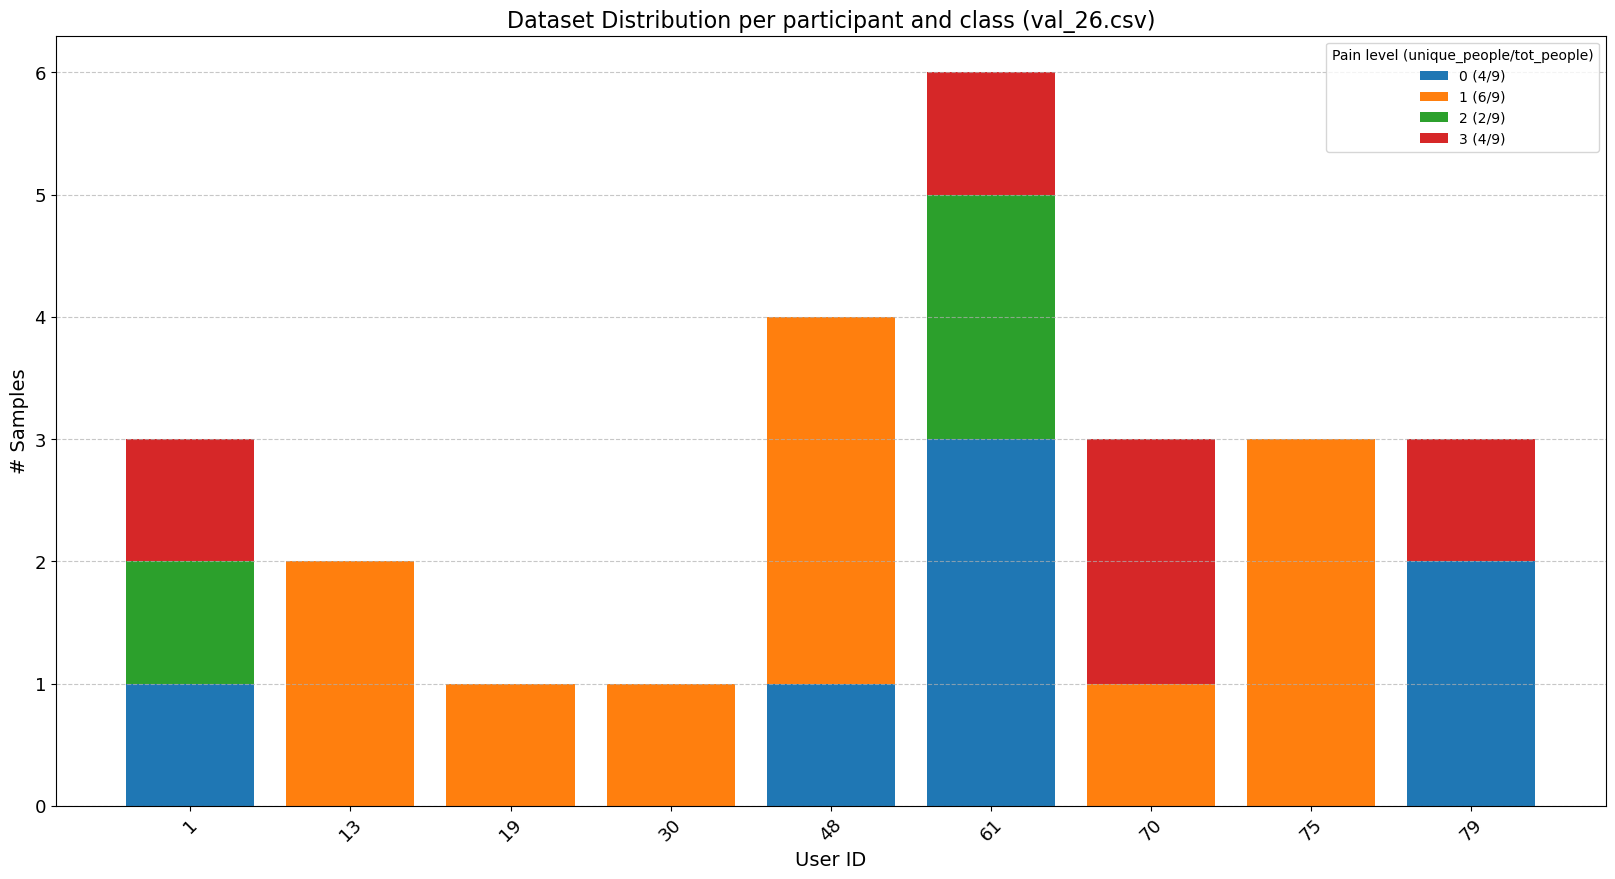

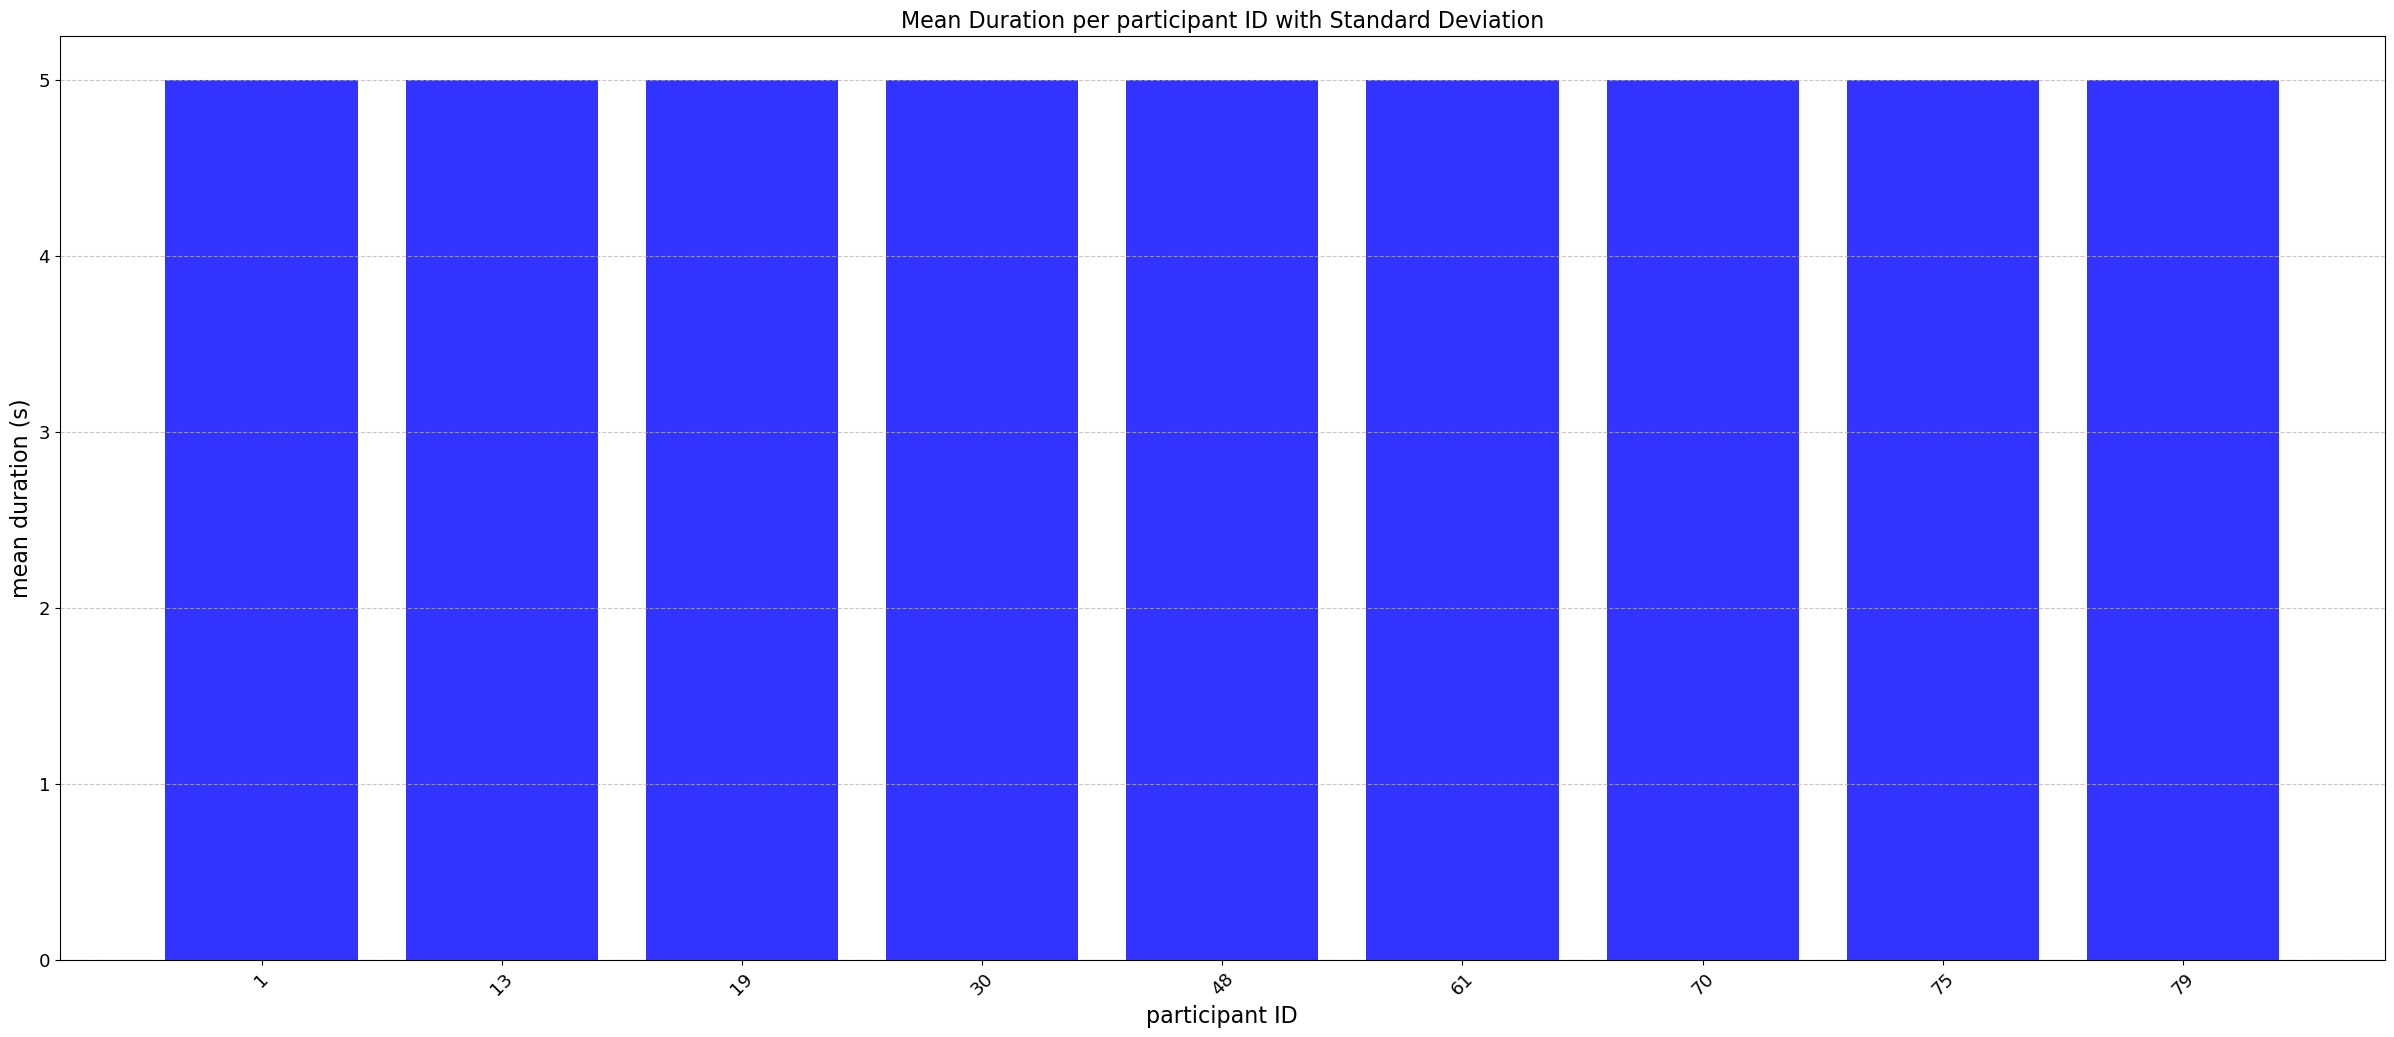

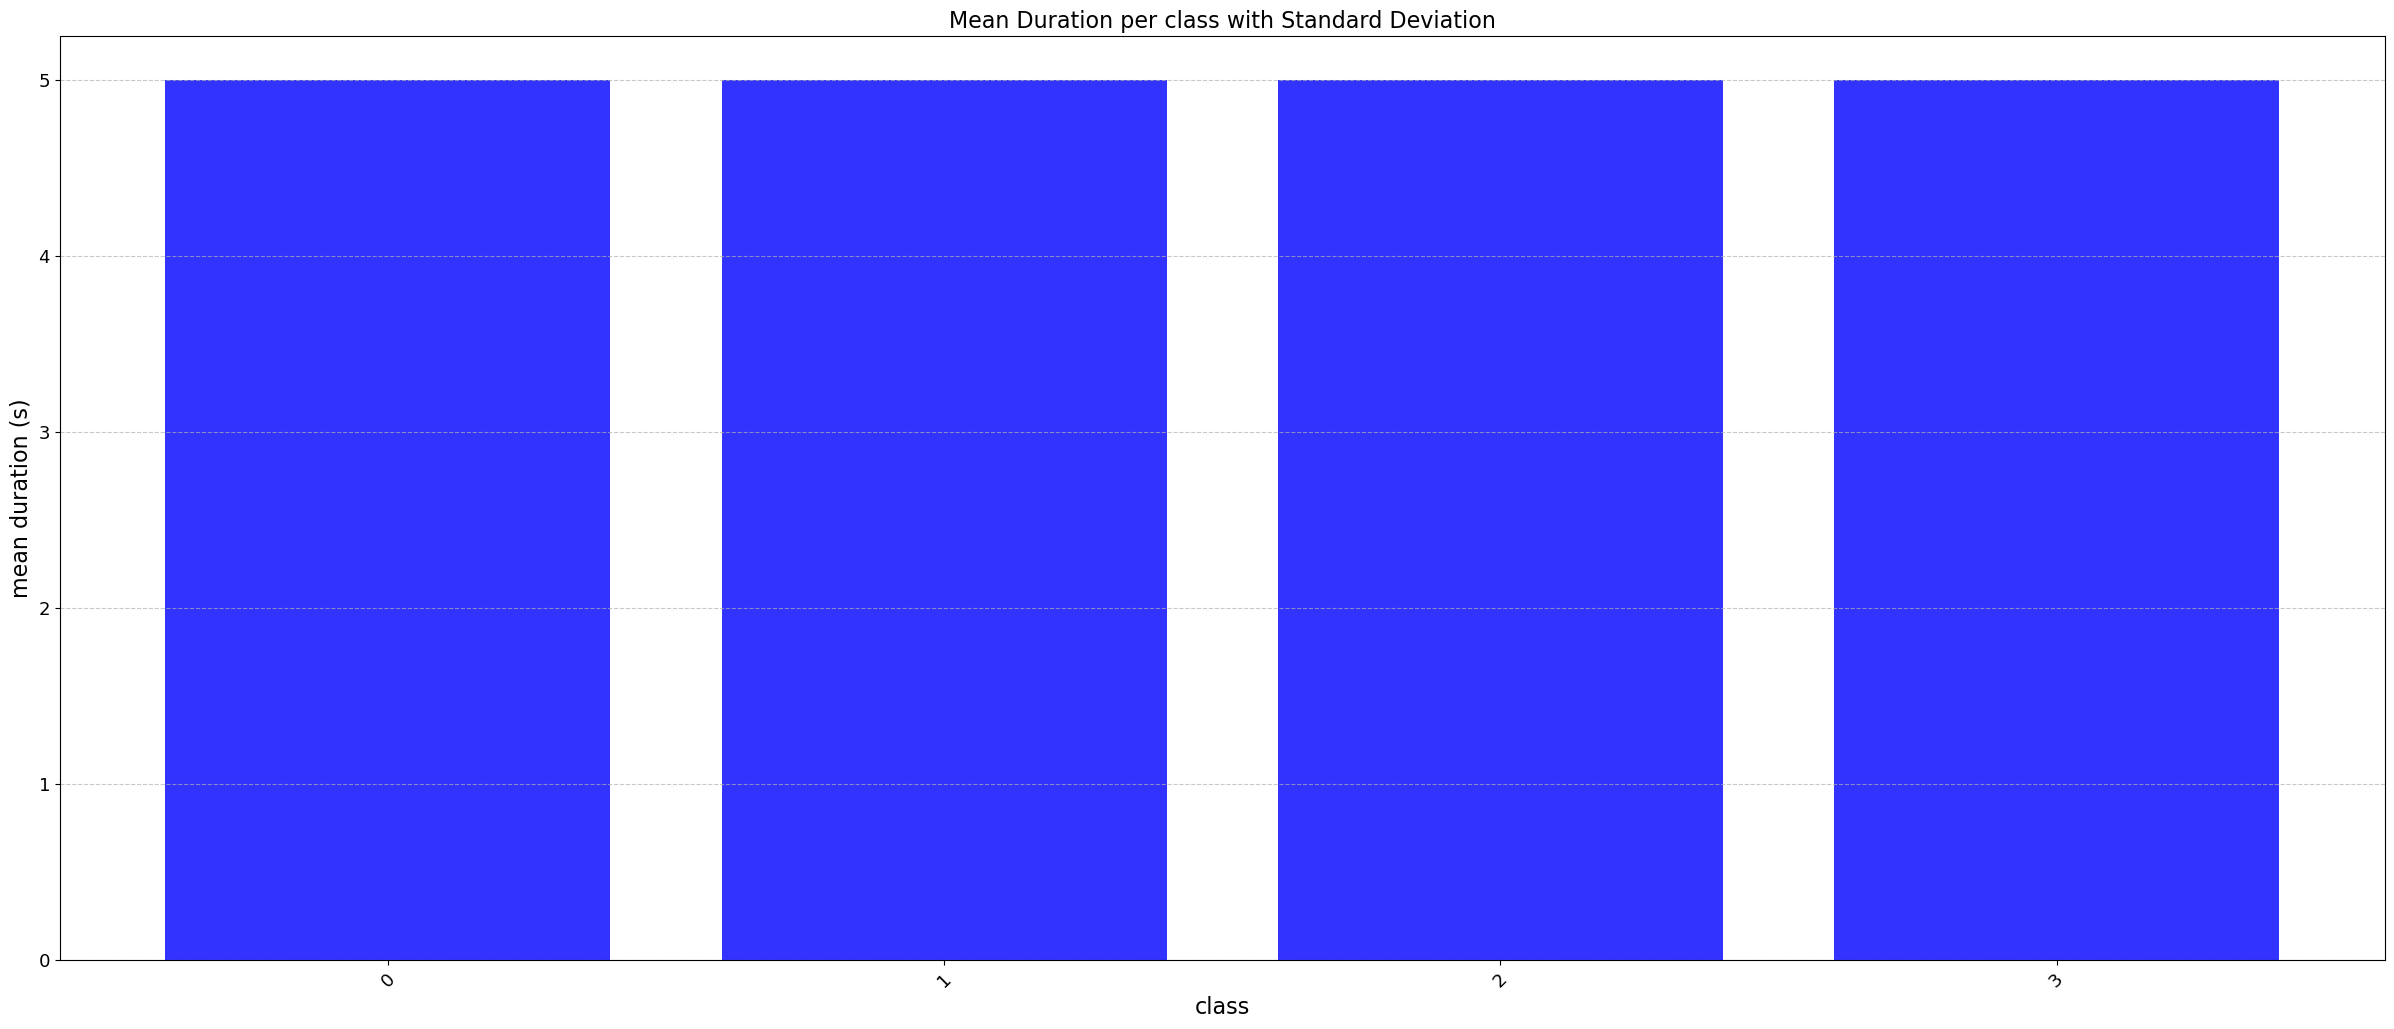

testdataset
Set path_labels: partA/starting_point/test_23.csv


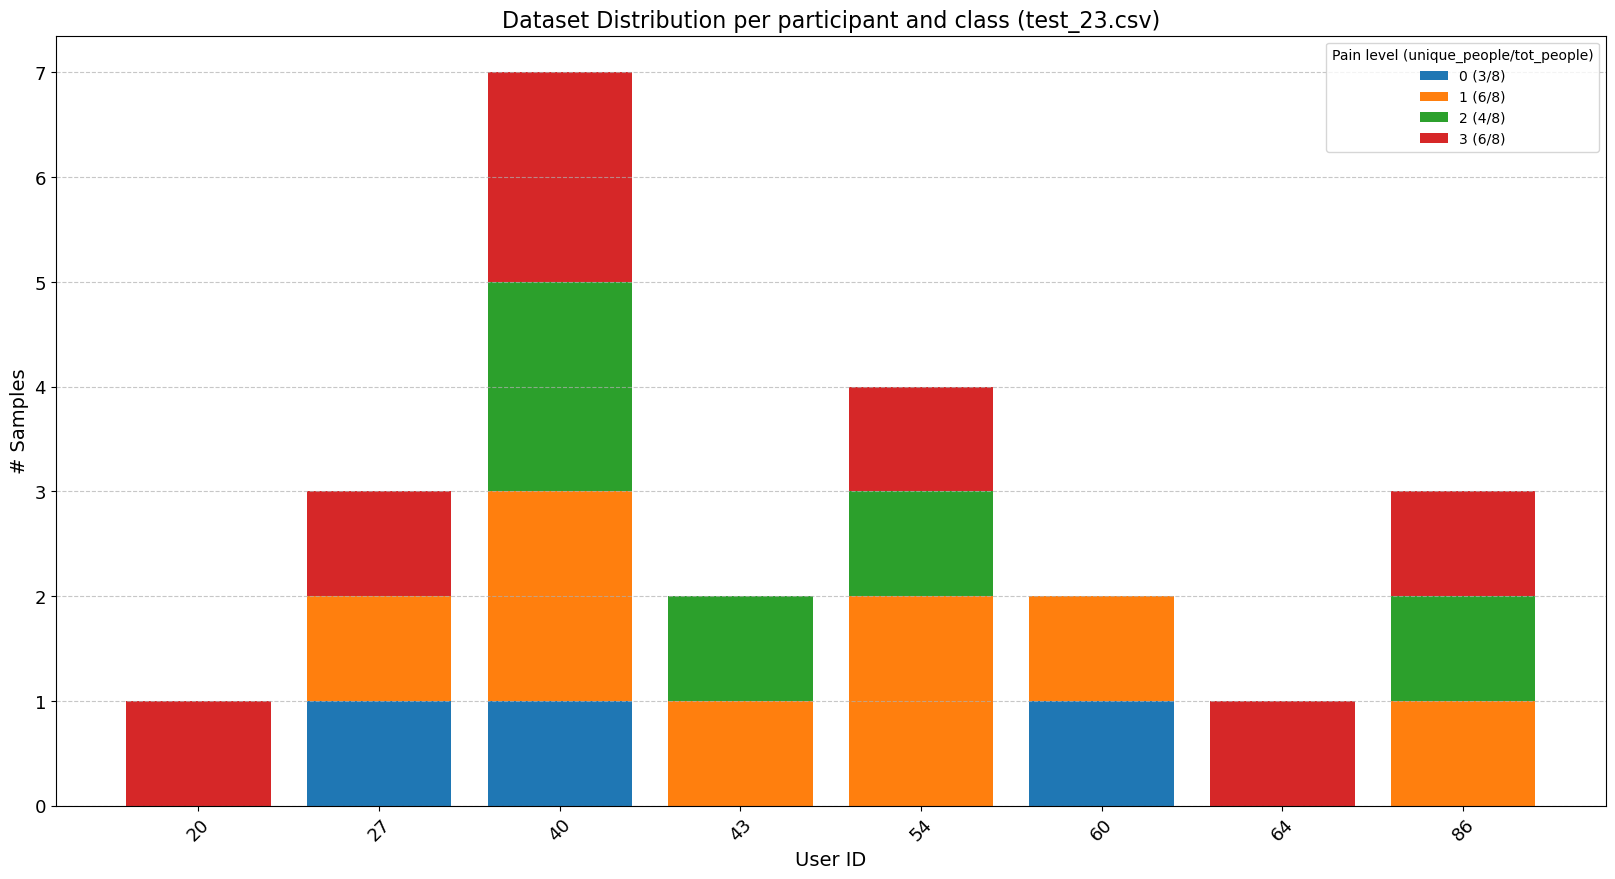

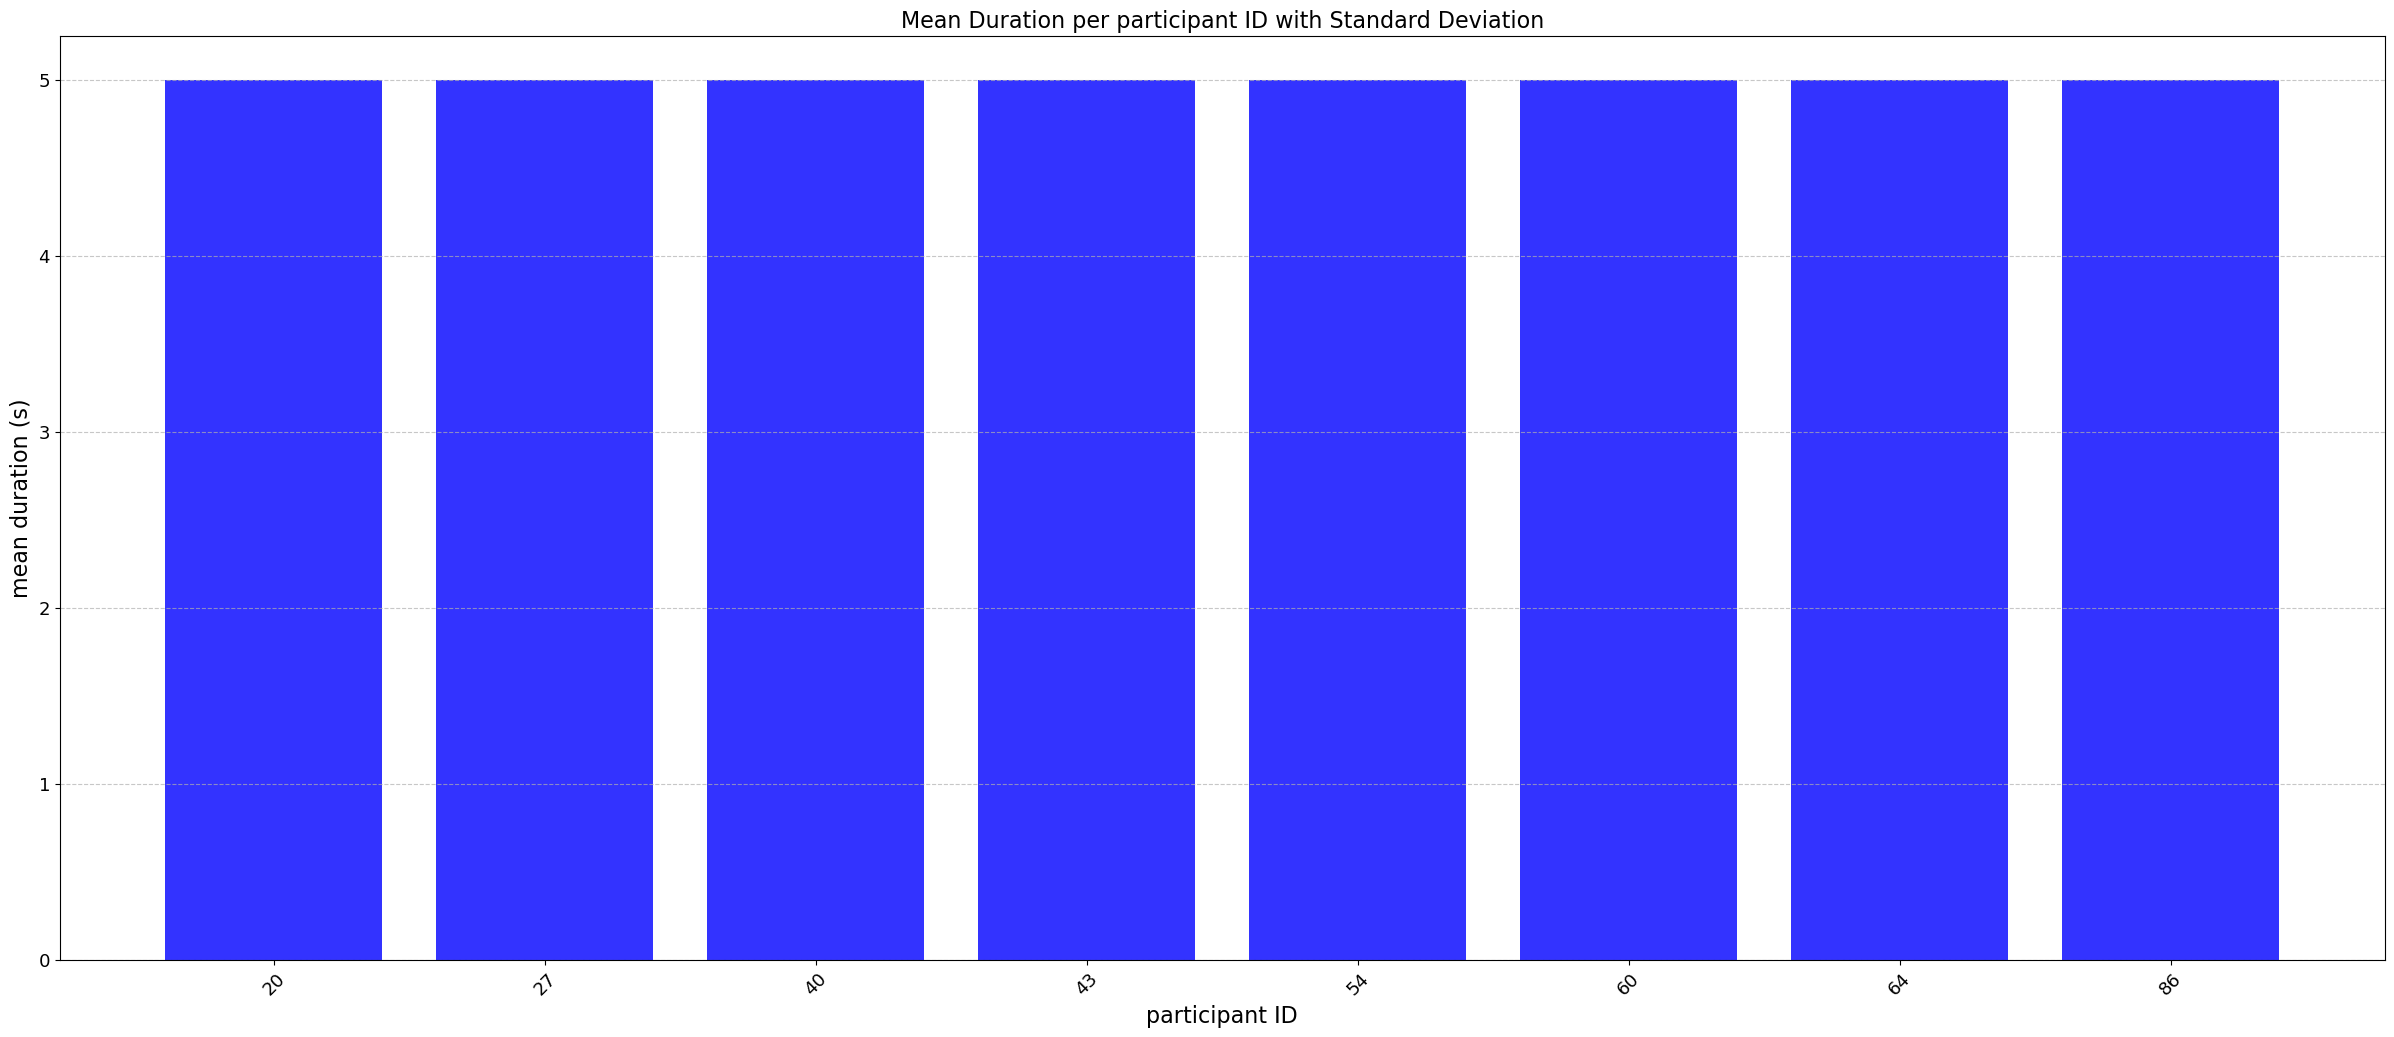

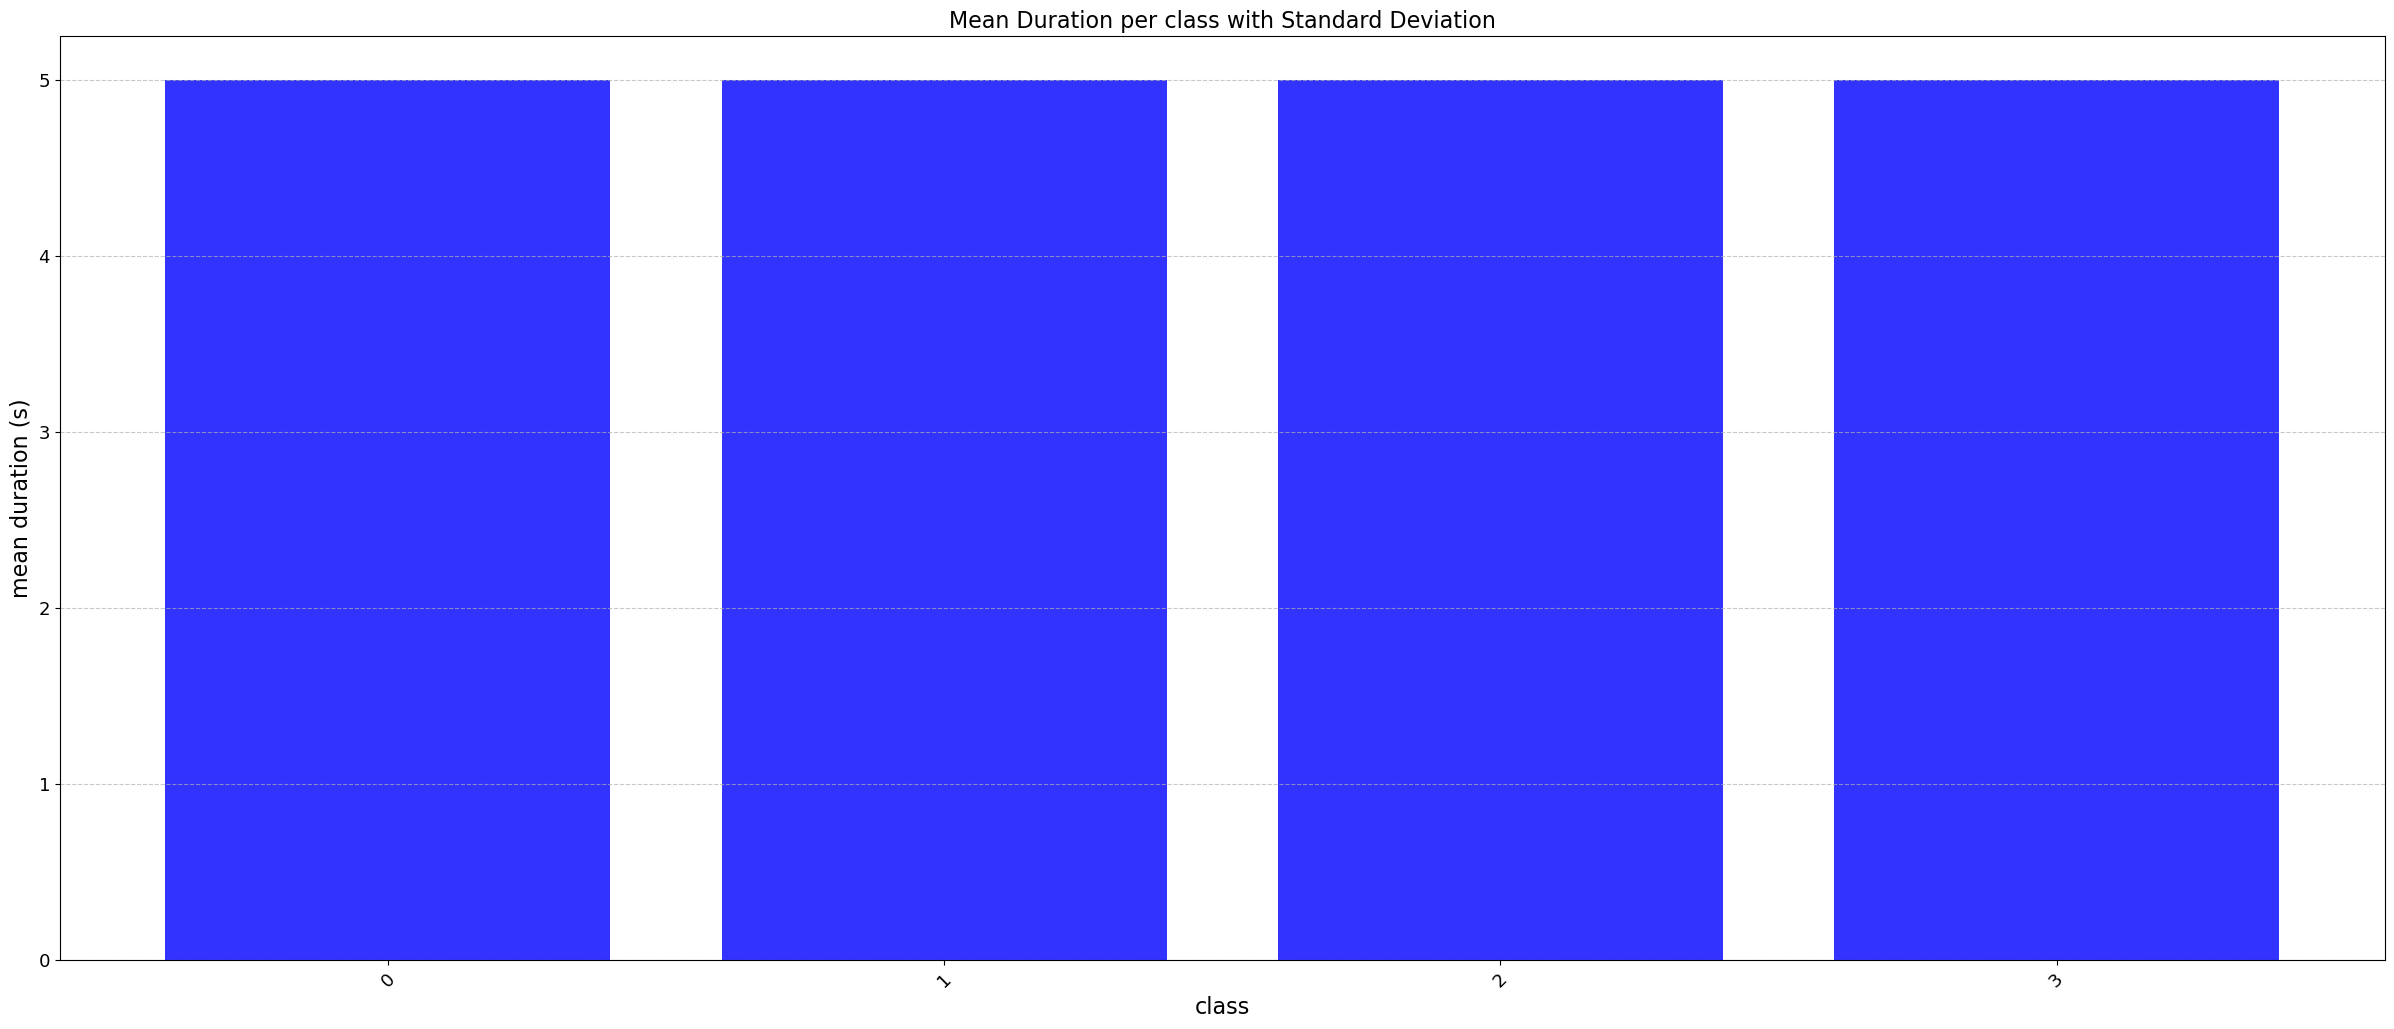

In [7]:
%load_ext autoreload
%autoreload 2

for key in path_dict.keys():
  print(key + 'dataset')
  model_advanced.dataset.set_path_labels(key)
  model_advanced.dataset.plot_dataset_distribution(per_class=True,per_partecipant=True)
  model_advanced.dataset.plot_distribution_mean_std_duration(per_class=True,per_partecipant=True)

GridSearch using SVR.-..
Set path_labels: partA/starting_point/val_26.csv
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature 

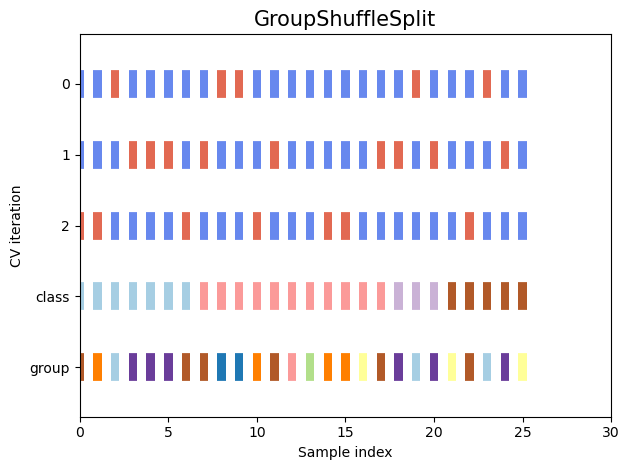

Best Parameters: {'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}
Best Score: -0.4716287219866544


In [8]:
%autoreload 2
param_grid = {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 1, 10, 100],
        }

path_validation = os.path.join('partA','starting_point','subsamples_5_20.csv')
path_training = os.path.join('partA','starting_point','subsamples_60_240.csv')

# GRID search
# model_advanced.dataset.set_path_labels(path_validation)
result = model_advanced.run_grid_search(param_grid=param_grid,k_cross_validation=3)

if result is not None:
  grid_search, list_split_indices, subjects_id, y = result
  head = SVR_head(svr_params=grid_search.best_params_)
  model_advanced.head = head

# #Training 
# model_advanced.train()

In [9]:
import pandas as pd
df = pd.DataFrame(grid_search.cv_results_)
df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.000567,0.000020,0.000415,0.000006,0.1,1.0,rbf,"{'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}",-0.048917,-1.333895,-0.032074,-0.471629,0.609753,1,-0.866542,-0.600684,-0.948358,-0.805195,0.148418
0,0.000837,0.000217,0.000494,0.000042,0.1,0.1,rbf,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}",-0.099782,-1.335540,-0.090824,-0.508715,0.584665,2,-0.883506,-0.601500,-0.961047,-0.815351,0.154493
4,0.000590,0.000027,0.000424,0.000007,1.0,0.1,rbf,"{'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}",-0.282538,-1.332888,-0.217012,-0.610813,0.511284,3,-0.819292,-0.603638,-0.889227,-0.770719,0.121545
5,0.000544,0.000014,0.000405,0.000004,1.0,1.0,rbf,"{'C': 1, 'epsilon': 1, 'kernel': 'rbf'}",-0.488368,-1.338655,-0.320828,-0.715950,0.445599,4,-0.839317,-0.606477,-0.912637,-0.786144,0.130522
2,0.000523,0.000008,0.000376,0.000003,0.1,10.0,rbf,"{'C': 0.1, 'epsilon': 10, 'kernel': 'rbf'}",-0.500000,-1.333333,-0.500000,-0.777778,0.392837,5,-1.021739,-0.850000,-1.071429,-0.981056,0.094865
3,0.000668,0.000045,0.000439,0.000041,0.1,100.0,rbf,"{'C': 0.1, 'epsilon': 100, 'kernel': 'rbf'}",-0.500000,-1.333333,-0.500000,-0.777778,0.392837,5,-1.021739,-0.850000,-1.071429,-0.981056,0.094865
6,0.000540,0.000048,0.000375,0.000005,1.0,10.0,rbf,"{'C': 1, 'epsilon': 10, 'kernel': 'rbf'}",-0.500000,-1.333333,-0.500000,-0.777778,0.392837,5,-1.021739,-0.850000,-1.071429,-0.981056,0.094865
7,0.000507,0.000008,0.000380,0.000025,1.0,100.0,rbf,"{'C': 1, 'epsilon': 100, 'kernel': 'rbf'}",-0.500000,-1.333333,-0.500000,-0.777778,0.392837,5,-1.021739,-0.850000,-1.071429,-0.981056,0.094865
10,0.000570,0.000071,0.000374,0.000014,10.0,10.0,rbf,"{'C': 10, 'epsilon': 10, 'kernel': 'rbf'}",-0.500000,-1.333333,-0.500000,-0.777778,0.392837,5,-1.021739,-0.850000,-1.071429,-0.981056,0.094865
11,0.000510,0.000015,0.000365,0.000005,10.0,100.0,rbf,"{'C': 10, 'epsilon': 100, 'kernel': 'rbf'}",-0.500000,-1.333333,-0.500000,-0.777778,0.392837,5,-1.021739,-0.850000,-1.071429,-0.981056,0.094865


In [5]:
import pandas as pd

# Load the CSV files
subsamples_1 = pd.read_csv('partA/starting_point/test_23.csv', sep='\t')
subsamples_2 = pd.read_csv('partA/starting_point/train_191.csv', sep='\t')

col_to_check = 'subject_id'
# Extract the 4th element from each row
elements_1 = subsamples_1[col_to_check]
elements_2 = subsamples_2[col_to_check]

# Check for common elements
common_elements = elements_1[elements_1.isin(elements_2)]

if not common_elements.empty:
  print("There are common elements:")
else:
  print("There are no common elements.")

# List of elements in common
common_elements_list = common_elements.tolist()
print("Elements in common:", common_elements_list)


There are no common elements.
Elements in common: []


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training using SVR...
Set path_labels: partA/starting_point/val_26.csv
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size(

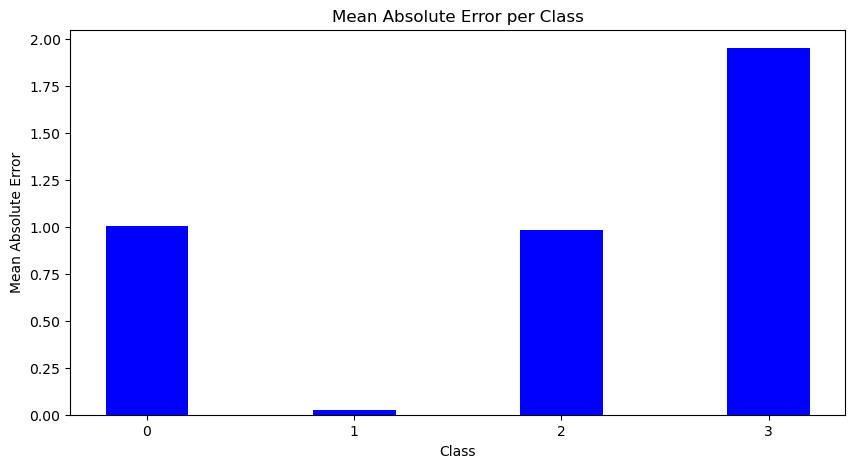

subject_ids [79 48  1 61 61 61 79 75 13 13 48 75 30 19 48 48 70 75 61  1 61 70 79  1
 61 70]


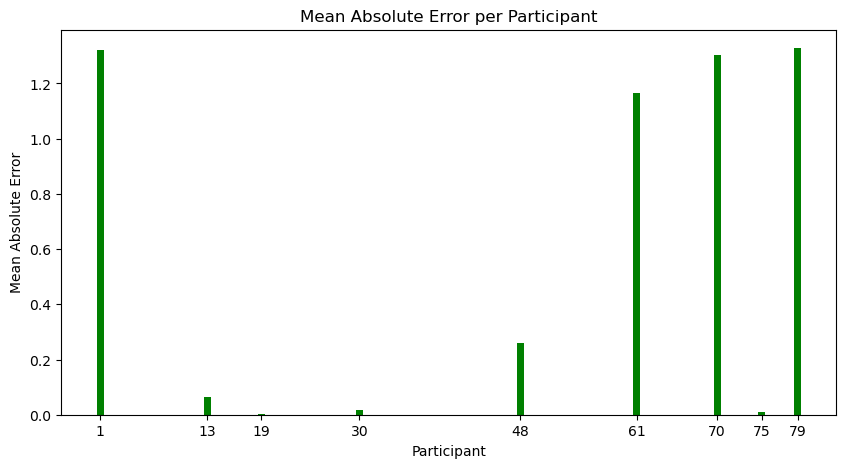

Time to complete: 24.46606707572937 seconds


In [10]:
%load_ext autoreload
%autoreload 2

start_time = time.time()
model_advanced.train()
end_time = time.time()
print(f'Time to complete: {end_time-start_time} seconds')
# list_frames = model_advanced.fit(stop_after=3,plot_dataset_split_distribution=True)
# list_frames


[['79\t112016_m_25\t0\tBL1\t7812\t112016_m_25-BL1-092']
 ['48\t100214_m_50\t0\tBL1\t4719\t100214_m_50-BL1-099']
 ['1\t071309_w_21\t0\tBL1\t6\t071309_w_21-BL1-086']
 ['61\t101809_m_59\t0\tBL1\t6011\t101809_m_59-BL1-091']
 ['61\t101809_m_59\t0\tBL1\t6020\t101809_m_59-BL1-100']
 ['61\t101809_m_59\t0\tBL1\t6007\t101809_m_59-BL1-087']
 ['79\t112016_m_25\t0\tBL1\t7819\t112016_m_25-BL1-099']
 ['75\t111409_w_63\t1\tPA1\t7422\t111409_w_63-PA1-006']
 ['13\t080209_w_26\t1\tPA1\t1231\t080209_w_26-PA1-044']
 ['13\t080209_w_26\t1\tPA1\t1236\t080209_w_26-PA1-063']
 ['48\t100214_m_50\t1\tPA1\t4724\t100214_m_50-PA1-006']
 ['75\t111409_w_63\t1\tPA1\t7440\t111409_w_63-PA1-080']
 ['30\t082809_m_26\t1\tPA1\t2935\t082809_m_26-PA1-048']
 ['19\t080714_m_23\t1\tPA1\t1826\t080714_m_23-PA1-025']
 ['48\t100214_m_50\t1\tPA1\t4721\t100214_m_50-PA1-001']
 ['48\t100214_m_50\t1\tPA1\t4726\t100214_m_50-PA1-009']
 ['70\t102514_w_40\t1\tPA1\t6931\t102514_w_40-PA1-052']
 ['75\t111409_w_63\t1\tPA1\t7435\t111409_w_63-PA1-05

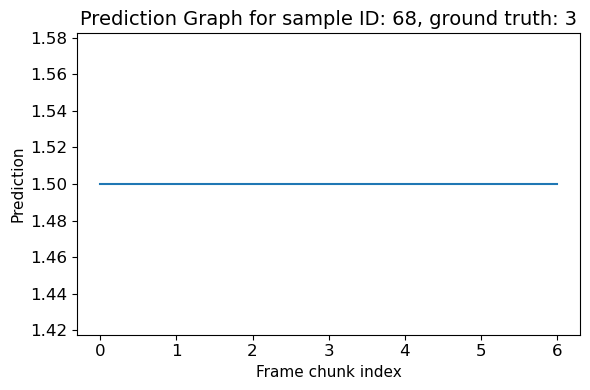

csv ['1' '071309_w_21' '3' 'PA3' '68' '071309_w_21-PA3-024']
input_video_path partA/video/video/071309_w_21/071309_w_21-PA3-024.mp4
all_labels [tensor([3, 3, 3, 3, 3, 3, 3], dtype=torch.int16)]
output_video_path: partA/video/custom_video/071309_w_21-PA3-024_70.mp4
input_video_path: partA/video/video/071309_w_21/071309_w_21-PA3-024.mp4
Saved extracted frames to partA/video/custom_video/071309_w_21-PA3-024_70.mp4


In [5]:
# model_advanced.dataset.set_path_labels('test')
# model_advanced.train()
# print('Plot prediction graph')
model_advanced.plot_prediction_graph(68,stride_window=20)


In [15]:
model_advanced.plot_prediction_graph_all([6,6011],stride_window=60)

Sliding shape torch.Size([3, 16])
features[1]->labels tensor([[0, 0, 0]], dtype=torch.int16)
Sliding shape torch.Size([3, 16])
features[1]->labels tensor([[0, 0, 0]], dtype=torch.int16)
all_labels [tensor([0, 0, 0], dtype=torch.int16), tensor([0, 0, 0], dtype=torch.int16)]
output_video_path: partA/video/custom_video/all_2.mp4
input_video_path: partA/video/video/071309_w_21/071309_w_21-BL1-086.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


input_video_path: partA/video/video/101809_m_59/101809_m_59-BL1-091.mp4
Saved extracted frames to partA/video/custom_video/all_2.mp4


[array([1.5, 1.5, 1.5]), array([1.5, 1.5, 1.5])]

In [12]:
for train, test in cp:
  intersection = set(train).intersection(set(test))
  if not intersection:
    print("Intersection is empty")
  else:
    print(f"Intersection is not empty: {intersection}")

Intersection is empty
Intersection is empty
Intersection is empty


In [17]:
import pandas as pd

model_advanced.dataset.set_path_labels('test')
start_time = time.time()
results = model_advanced.train(k_cross_validation=3)
end_time = time.time()

# # Sort the DataFrame by 'rank_test_score'
results_df = pd.DataFrame(results[1])
results_df['test_score'] = -results_df['test_score']
results_df['train_score'] = -results_df['train_score']
results_df.insert(results_df.columns.get_loc('estimator') + 1, 'kernel', results_df['estimator'].apply(lambda x: x.kernel))
results_df

Set path_labels: partA/starting_point/test_23.csv
Training using SVR with k-fold cross-validation...
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature extracetion done
X.shape (23, 768)
y.shapey (23,)
Keys: dict_keys(['fit_tim

,fit_time,score_time,estimator,kernel,test_score,train_score
0,0.001075,0.000438,"SVR(C=1, epsilon=10)",rbf,0.900000,0.944444
1,0.000530,0.000386,"SVR(C=1, epsilon=10)",rbf,0.666667,1.029412
2,0.000500,0.000392,"SVR(C=1, epsilon=10)",rbf,1.000000,0.911765
